# Pure FNO (NeuralOperator) — 1D x(t) → y(t) training notebook (leakage-safe)

This notebook trains a **pure FNO-1D** to learn **x(t) → y(t)**.

Key fixes / features:
- **Train/Val/Test split happens BEFORE preprocessing**.
- **Normalization stats are computed using TRAIN ONLY** (prevents data leakage).
- Optional preprocessing toggles:
  - `remove_dc` (subtract mean per-sample)
  - `normalize` (`none` / `standard` / `maxabs`) — train-only stats
  - `per_sample_rms` (optional)
  - `add_time_channel` (adds a normalized time coordinate to **X only**)
- Quick sanity checks include:
  - time-domain plot
  - **linear** FFT magnitude (no semilogy)
  - phase (wrapped) + **phase difference** (masked where magnitude is tiny)

Assumption: your segment is **0.3 seconds** (e.g., [0, 0.3] s).  
If `T=57600`, then `fs = 57600 / 0.3 = 192000 Hz`.


## 0) Setup

In [ ]:

# If needed (fresh env), uncomment:
# !pip -q install neuraloperator torch numpy scipy matplotlib tqdm soundfile

import os, json, random, math
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Optional, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt``

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Torch: 2.5.1
CUDA: True


c:\Users\Euije Lee\anaconda3\envs\p311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

## 1) Load data

Choose one:
- **Option A (recommended)**: `.npz` with arrays `X` and `Y`
  - `X`: `[N,T]` or `[N,C_in,T]`
  - `Y`: `[N,T]` or `[N,C_out,T]`
- **Option B**: paired WAV folders (`x_dir`, `y_dir`) matched by filename stem


In [4]:

def ensure_3d(arr: np.ndarray) -> np.ndarray:
    """Convert to [N, C, T]. Accepts [N,T] or [N,C,T]."""
    arr = np.asarray(arr)
    if arr.ndim == 2:
        return arr[:, None, :]
    if arr.ndim == 3:
        return arr
    raise ValueError(f"Expected 2D or 3D array, got shape {arr.shape}")

def load_npz(npz_path: str, x_key="X", y_key="Y") -> Tuple[np.ndarray, np.ndarray, Dict]:
    npz = np.load(npz_path, allow_pickle=True)
    X = ensure_3d(npz[x_key]).astype(np.float32)
    Y = ensure_3d(npz[y_key]).astype(np.float32)
    meta = {}
    for k in npz.files:
        if k not in (x_key, y_key):
            try:
                meta[k] = npz[k].item() if npz[k].dtype == object else npz[k]
            except Exception:
                pass
    return X, Y, meta

def load_wav_pairs(x_dir: str, y_dir: str, sr_expected: Optional[int]=None) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """Load paired wav files from x_dir and y_dir. Matching is by filename stem."""
    try:
        import soundfile as sf
        def read_fn(p):
            data, sr = sf.read(p, dtype="float32")
            return sr, data
    except Exception:
        from scipy.io import wavfile
        def read_fn(p):
            sr, data = wavfile.read(p)
            data = data.astype(np.float32)
            if data.dtype.kind in ("i", "u"):
                maxv = np.iinfo(data.dtype).max
                data = data / maxv
            return sr, data

    x_dir = Path(x_dir)
    y_dir = Path(y_dir)
    x_files = sorted(x_dir.glob("*.wav"))
    if not x_files:
        raise FileNotFoundError(f"No wav files found in {x_dir}")

    y_map = {p.stem: p for p in y_dir.glob("*.wav")}
    pairs = [(xf, y_map.get(xf.stem)) for xf in x_files if xf.stem in y_map]
    if not pairs:
        raise FileNotFoundError("No matching wav stems found between x_dir and y_dir.")

    X_list, Y_list = [], []
    sr0 = None
    for xf, yf in tqdm(pairs, desc="Loading WAV pairs"):
        sr_x, x = read_fn(str(xf))
        sr_y, y = read_fn(str(yf))
        if sr_x != sr_y:
            raise ValueError(f"Sample rate mismatch for {xf.name}: x={sr_x}, y={sr_y}")
        if sr0 is None:
            sr0 = sr_x
        if sr_expected is not None and sr_x != sr_expected:
            raise ValueError(f"Expected sr={sr_expected}, got {sr_x} for {xf.name}")

        x = np.asarray(x).squeeze()
        y = np.asarray(y).squeeze()
        if x.ndim > 1: x = x[:, 0]
        if y.ndim > 1: y = y[:, 0]

        X_list.append(x[None, :])
        Y_list.append(y[None, :])

    T = min(min(a.shape[-1] for a in X_list), min(b.shape[-1] for b in Y_list))
    X = np.stack([a[..., :T] for a in X_list], axis=0).astype(np.float32)
    Y = np.stack([b[..., :T] for b in Y_list], axis=0).astype(np.float32)

    meta = {"sample_rate": int(sr0), "T": int(T), "N": int(X.shape[0])}
    return X, Y, meta

USE_LOADER = "wav"  # "npz" or "wav"

NPZ_PATH = "./data_xy.npz"   # <-- change

X_WAV_DIR = "./data/x_t"       # <-- change
Y_WAV_DIR = "./data/y_t"      # <-- change
SR_EXPECTED = None           # e.g., 48000

if USE_LOADER == "npz":
    X, Y, meta = load_npz(NPZ_PATH, x_key="X", y_key="Y")
else:
    X, Y, meta = load_wav_pairs(X_WAV_DIR, Y_WAV_DIR, sr_expected=SR_EXPECTED)

print("Loaded:")
print("  X:", X.shape, X.dtype)
print("  Y:", Y.shape, Y.dtype)
print("  meta keys:", list(meta.keys()))


Loading WAV pairs: 100%|██████████| 2322/2322 [00:00<00:00, 3143.97it/s]


Loaded:
  X: (2322, 1, 57600) float32
  Y: (2322, 1, 57600) float32
  meta keys: ['sample_rate', 'T', 'N']


## 2) Resolve sample rate and duration

In [5]:
# --- Step 2) Resolve sample rate and duration (+ optional resampling to 48k) ---
from scipy.signal import resample_poly

SEG_DUR_SEC = 0.3         # you said data is [0, 0.3] sec
TARGET_FS   = 48000       # resample target

# 1) resolve fs_in
T_in = X.shape[-1]
if "sample_rate" in meta:
    fs_in = int(meta["sample_rate"])
    print("fs_in from meta:", fs_in)
else:
    fs_in = int(round(T_in / SEG_DUR_SEC))
    print("fs_in inferred from T/duration:", fs_in)

print("Before resample:")
print("  X:", X.shape, "Y:", Y.shape)
print("  fs_in:", fs_in, "duration:", T_in / fs_in, "sec")

# 2) resample if needed (vectorized over axis=-1)
if fs_in != TARGET_FS:
    g = math.gcd(fs_in, TARGET_FS)
    up = TARGET_FS // g
    down = fs_in // g
    print(f"Resampling: {fs_in} -> {TARGET_FS} (up={up}, down={down})")

    # [N, C, T] resampling along time axis
    X = resample_poly(X, up, down, axis=-1).astype(np.float32)
    Y = resample_poly(Y, up, down, axis=-1).astype(np.float32)

    meta["sample_rate"] = TARGET_FS

# 3) final fs and duration
fs = int(meta["sample_rate"]) if "sample_rate" in meta else TARGET_FS
T = X.shape[-1]

print("After resample:")
print("  X:", X.shape, "Y:", Y.shape)
print("  fs:", fs, "duration:", T / fs, "sec")

# After resample, before split
KEEP_FRAC = 0.1  # 1/5
T = X.shape[-1]
T_keep = int(T * KEEP_FRAC)

X = X[..., :T_keep]
Y = Y[..., :T_keep]

T = X.shape[-1]
print("Cropped:")
print("  T_keep:", T_keep, "duration:", T_keep / fs, "sec")
print("  X:", X.shape, "Y:", Y.shape)
print("  fs:", fs, "duration:", T / fs, "sec")

fs_in from meta: 192000
Before resample:
  X: (2322, 1, 57600) Y: (2322, 1, 57600)
  fs_in: 192000 duration: 0.3 sec
Resampling: 192000 -> 48000 (up=1, down=4)
After resample:
  X: (2322, 1, 14400) Y: (2322, 1, 14400)
  fs: 48000 duration: 0.3 sec
Cropped:
  T_keep: 1440 duration: 0.03 sec
  X: (2322, 1, 1440) Y: (2322, 1, 1440)
  fs: 48000 duration: 0.03 sec


## 3) Train/Val/Test split (BEFORE preprocessing)

This is critical for leakage-safe normalization.


In [6]:

@dataclass
class SplitConfig:
    seed: int = 42
    frac_train: float = 0.8
    frac_val: float = 0.1
    batch_size: int = 16
    num_workers: int = 0
    pin_memory: bool = True

cfg_split = SplitConfig(batch_size=16)

N = X.shape[0]
rng = np.random.default_rng(cfg_split.seed)
idx = np.arange(N)
rng.shuffle(idx)

n_train = int(cfg_split.frac_train * N)
n_val   = int(cfg_split.frac_val   * N)

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val,   Y_val   = X[val_idx],   Y[val_idx]
X_test,  Y_test  = X[test_idx],  Y[test_idx]

print("Split sizes:", len(train_idx), len(val_idx), len(test_idx))


Split sizes: 1857 232 233


## 4) Preprocessing (train-only stats)

Order:
1) remove DC per-sample (optional)
2) per-sample RMS normalization (optional)
3) dataset-level normalization using **TRAIN stats only** (optional)
4) add time channel to **X only** (optional)


In [7]:

@dataclass
class PreprocConfig:
    remove_dc: bool = True
    per_sample_rms: bool = False
    normalize: str = "standard"  # "none" | "standard" | "maxabs"
    add_time_channel: bool = True
    eps: float = 1e-8

cfg_prep = PreprocConfig(
    remove_dc=False,
    per_sample_rms=False,
    normalize="none",
    add_time_channel=True
)

def remove_dc_per_sample(A: np.ndarray) -> np.ndarray:
    return A - A.mean(axis=-1, keepdims=True)

def rms_per_sample(A: np.ndarray, eps=1e-8) -> np.ndarray:
    rms = np.sqrt(np.mean(A**2, axis=-1, keepdims=True) + eps)
    return A / rms

def compute_norm_stats_train_only(Xtr: np.ndarray, Ytr: np.ndarray, mode: str, eps: float=1e-8):
    if mode == "none":
        return None
    if mode == "standard":
        x_mean = Xtr.mean(axis=(0,2), keepdims=True)
        x_std  = Xtr.std(axis=(0,2), keepdims=True) + eps
        y_mean = Ytr.mean(axis=(0,2), keepdims=True)
        y_std  = Ytr.std(axis=(0,2), keepdims=True) + eps
        return {"mode": mode, "x_mean": x_mean, "x_std": x_std, "y_mean": y_mean, "y_std": y_std}
    if mode == "maxabs":
        x_scale = np.max(np.abs(Xtr), axis=(0,2), keepdims=True) + eps
        y_scale = np.max(np.abs(Ytr), axis=(0,2), keepdims=True) + eps
        return {"mode": mode, "x_scale": x_scale, "y_scale": y_scale}
    raise ValueError(f"Unknown normalize mode: {mode}")

def apply_dataset_norm(Xa: np.ndarray, Ya: np.ndarray, stats: Optional[dict]):
    if stats is None or stats.get("mode") == "none":
        return Xa, Ya
    if stats["mode"] == "standard":
        Xn = (Xa - stats["x_mean"]) / stats["x_std"]
        Yn = (Ya - stats["y_mean"]) / stats["y_std"]
        return Xn, Yn
    if stats["mode"] == "maxabs":
        return Xa / stats["x_scale"], Ya / stats["y_scale"]
    raise ValueError("Bad stats dict")

def add_time_channel(Xa: np.ndarray) -> np.ndarray:
    N, C, T = Xa.shape
    t = np.linspace(0.0, 0.3, T, dtype=np.float32)[None, None, :]
    t = np.repeat(t, N, axis=0)
    return np.concatenate([Xa, t], axis=1)

def preprocess_split(Xa: np.ndarray, Ya: np.ndarray, cfg: PreprocConfig, stats: Optional[dict]):
    Xp, Yp = Xa.copy(), Ya.copy()

    if cfg.remove_dc:
        Xp = remove_dc_per_sample(Xp)
        Yp = remove_dc_per_sample(Yp)

    if cfg.per_sample_rms:
        Xp = rms_per_sample(Xp, eps=cfg.eps)
        Yp = rms_per_sample(Yp, eps=cfg.eps)

    Xp, Yp = apply_dataset_norm(Xp, Yp, stats)

    if cfg.add_time_channel:
        Xp = add_time_channel(Xp)

    return Xp.astype(np.float32), Yp.astype(np.float32)

# ---- train-only stats computed on train after optional per-sample transforms ----
X_train_tmp, Y_train_tmp = X_train.copy(), Y_train.copy()
if cfg_prep.remove_dc:
    X_train_tmp = remove_dc_per_sample(X_train_tmp)
    Y_train_tmp = remove_dc_per_sample(Y_train_tmp)
if cfg_prep.per_sample_rms:
    X_train_tmp = rms_per_sample(X_train_tmp, eps=cfg_prep.eps)
    Y_train_tmp = rms_per_sample(Y_train_tmp, eps=cfg_prep.eps)

norm_stats = compute_norm_stats_train_only(X_train_tmp, Y_train_tmp, cfg_prep.normalize, eps=cfg_prep.eps)

X_train_n, Y_train_n = preprocess_split(X_train, Y_train, cfg_prep, norm_stats)
X_val_n,   Y_val_n   = preprocess_split(X_val,   Y_val,   cfg_prep, norm_stats)
X_test_n,  Y_test_n  = preprocess_split(X_test,  Y_test,  cfg_prep, norm_stats)

print("After preprocessing:")
print("  X_train_n:", X_train_n.shape, X_train_n.dtype)
print("  Y_train_n:", Y_train_n.shape, Y_train_n.dtype)


After preprocessing:
  X_train_n: (1857, 2, 1440) float32
  Y_train_n: (1857, 1, 1440) float32


## 5) Quick sanity checks (linear magnitude + phase)

- magnitude: **linear**
- phase: wrapped degrees in [-180, 180]
- mask phase where magnitude is below (max + `mag_floor_db`)
- show phase difference: ∠(Y·conj(X))


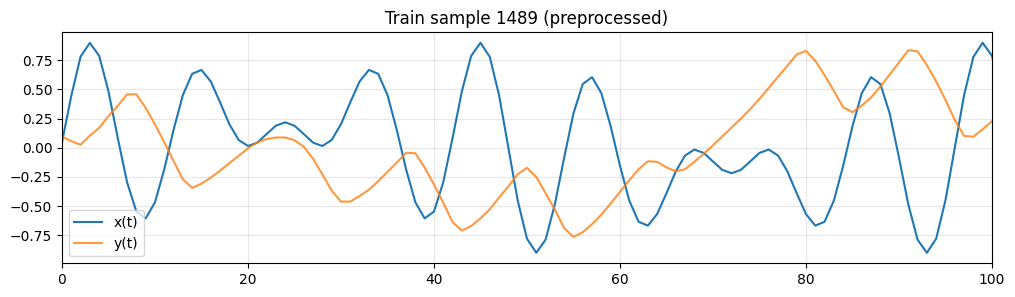

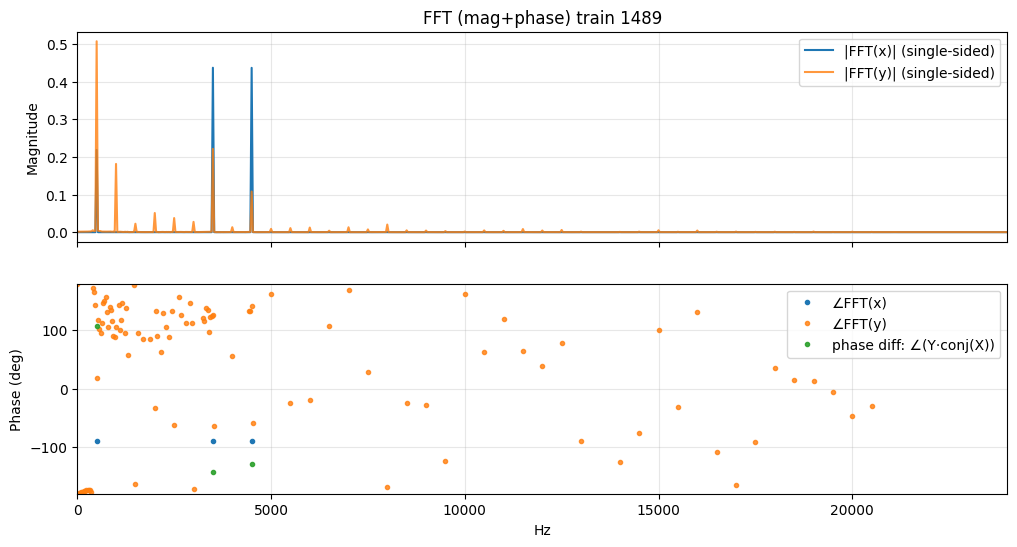

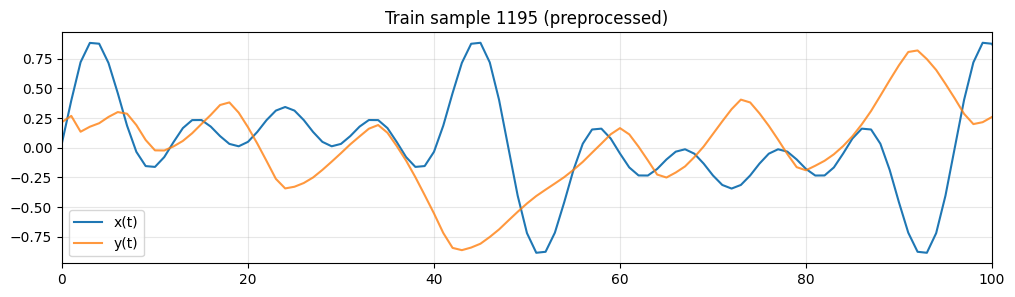

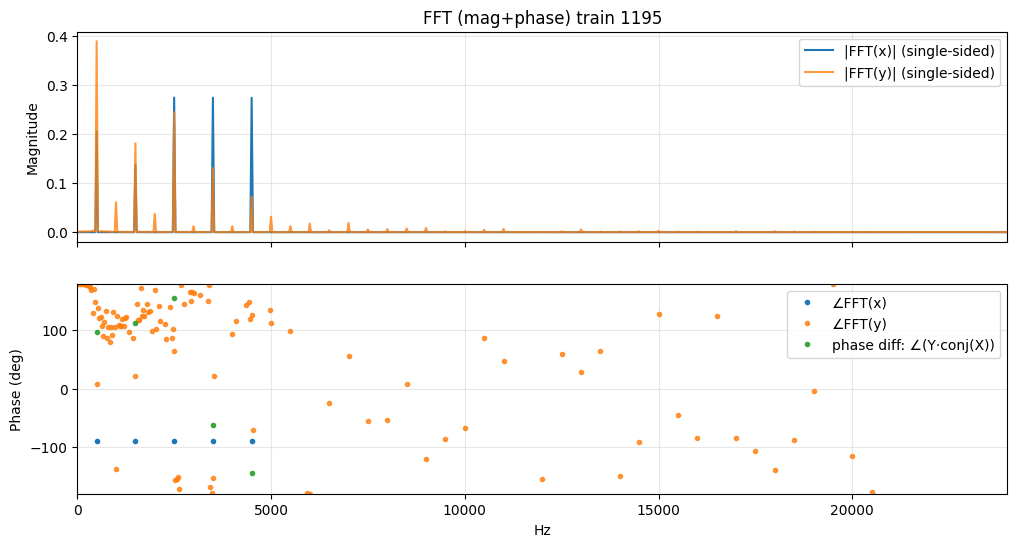

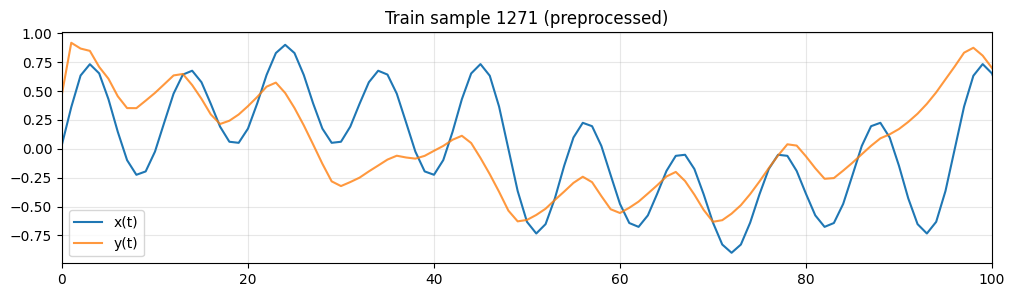

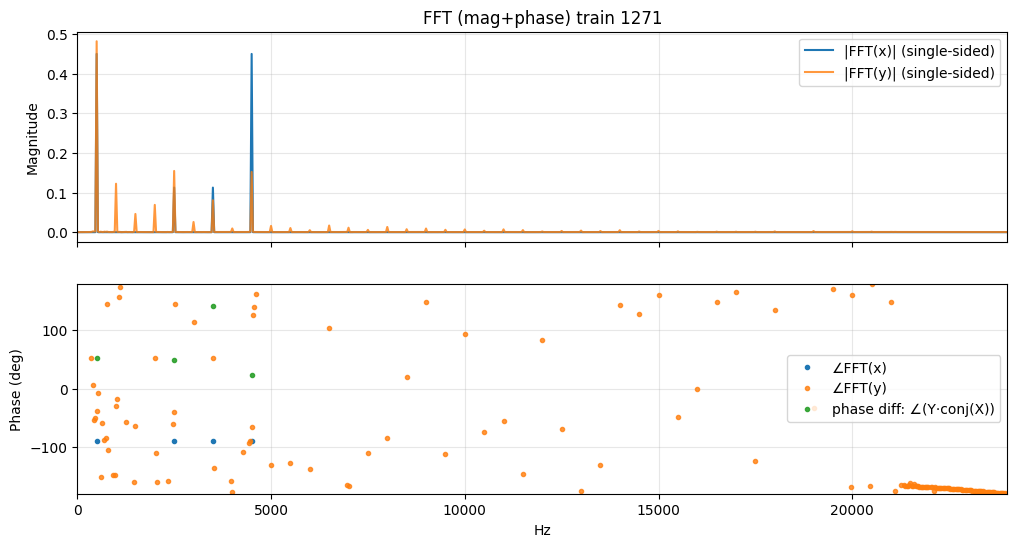

In [ ]:

def plot_sample_xy(Xa, Ya, idx=0, title=None, max_points=6000, t_xlim_samples=2000):
    x = Xa[idx, 0]
    y = Ya[idx, 0]
    T = x.shape[-1]
    step = max(1, T // max_points)

    plt.figure(figsize=(12, 3))
    plt.plot(x[::step], label="x(t)")
    plt.plot(y[::step], label="y(t)", alpha=0.8)
    plt.legend()
    plt.grid(True, alpha=0.3)
    if title:
        plt.title(title)
    # x-axis is sample index after downsample
    # plt.xlim(0, min(t_xlim_samples, T//step))
    plt.xlim(0, 100)
    plt.show()

def plot_fft_mag_phase_linear(x, y, fs, title=None, f_xlim=24000, mag_floor_db=-60, show_phase_diff=True):
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    N = len(x)

    Xf = np.fft.rfft(x)
    Yf = np.fft.rfft(y)
    f  = np.fft.rfftfreq(N, d=1.0/fs)

    magX = np.abs(Xf) / N
    magY = np.abs(Yf) / N
    if magX.size > 2:
        magX[1:-1] *= 2
        magY[1:-1] *= 2

    phX = np.rad2deg(np.angle(Xf))
    phY = np.rad2deg(np.angle(Yf))
    if show_phase_diff:
        phD = np.rad2deg(np.angle(Yf * np.conj(Xf)))

    def db(a): return 20*np.log10(np.maximum(a, 1e-12))
    thrX = db(magX).max() + mag_floor_db
    thrY = db(magY).max() + mag_floor_db
    mX = db(magX) >= thrX
    mY = db(magY) >= thrY

    phX_plot = np.where(mX, phX, np.nan)
    phY_plot = np.where(mY, phY, np.nan)
    if show_phase_diff:
        mD = mX & mY
        phD_plot = np.where(mD, phD, np.nan)

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    ax[0].plot(f, magX, label="|FFT(x)| (single-sided)")
    ax[0].plot(f, magY, label="|FFT(y)| (single-sided)", alpha=0.8)
    ax[0].set_ylabel("Magnitude")
    ax[0].grid(True, alpha=0.3)
    ax[0].legend()
    if title:
        ax[0].set_title(title)

    ax[1].plot(f, phX_plot, ".", label="∠FFT(x)")
    ax[1].plot(f, phY_plot, ".", label="∠FFT(y)", alpha=0.8)
    if show_phase_diff:
        ax[1].plot(f, phD_plot, ".", label="phase diff: ∠(Y·conj(X))", alpha=0.9)

    ax[1].set_ylabel("Phase (deg)")
    ax[1].set_xlabel("Hz")
    ax[1].set_ylim(-180, 180)
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()

    ax[1].set_xlim(0, f_xlim)
    plt.show()

for _ in range(2):
    i = np.random.randint(0, X_train_n.shape[0])
    plot_sample_xy(X_train_n, Y_train_n, idx=i, title=f"Train sample {i} (preprocessed)")
    plot_fft_mag_phase_linear(X_train_n[i,0], Y_train_n[i,0], fs=fs, title=f"FFT (mag+phase) train {i}")


## 6) Dataset + DataLoaders

In [10]:

class XYDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.Y[i]

ds_train = XYDataset(X_train_n, Y_train_n)
ds_val   = XYDataset(X_val_n,   Y_val_n)
ds_test  = XYDataset(X_test_n,  Y_test_n)

dl_train = DataLoader(ds_train, batch_size=cfg_split.batch_size, shuffle=True,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)
dl_val   = DataLoader(ds_val, batch_size=cfg_split.batch_size, shuffle=False,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)
dl_test  = DataLoader(ds_test, batch_size=cfg_split.batch_size, shuffle=False,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)

len(ds_train), len(ds_val), len(ds_test)


(1857, 232, 233)

## 7) Pure FNO-1D model (NeuralOperator)

Tries NeuralOperator first; falls back if import path differs.


In [17]:
class GainWrapper(nn.Module):
    def __init__(self, base_model, init_gain=1.0, init_sign=1.0):
        super().__init__()
        self.base = base_model
        self.log_gain = nn.Parameter(torch.tensor(float(np.log(init_gain)), dtype=torch.float32))
        # sign을 연속값으로 학습시키고 tanh로 -1~1로 제한
        self.sign_raw = nn.Parameter(torch.tensor(float(np.arctanh(0.9*init_sign)), dtype=torch.float32))

    def forward(self, x):
        gain = torch.exp(self.log_gain) * torch.tanh(self.sign_raw)
        return self.base(x) * gain


def build_fno1d(in_channels: int, out_channels: int,
               n_modes: int = 64, hidden_channels: int = 64,
               n_layers: int = 4):
    try:
        import neuralop  # noqa: F401
        try:
            from neuralop.models import FNO1d
            return FNO1d(
                n_modes=n_modes,
                hidden_channels=hidden_channels,
                in_channels=in_channels,
                out_channels=out_channels,
                n_layers=n_layers
            )
        except Exception:
            pass
        try:
            from neuralop.models.fno import FNO
            return FNO(
                n_modes=(n_modes,),
                hidden_channels=hidden_channels,
                in_channels=in_channels,
                out_channels=out_channels,
                n_layers=n_layers
            )
        except Exception:
            pass
    except Exception:
        pass

    print("WARNING: NeuralOperator import failed. Using minimal custom FNO-like baseline.")

    class SpectralConv1d(nn.Module):
        def __init__(self, in_ch, out_ch, modes):
            super().__init__()
            self.modes = modes
            self.weight = nn.Parameter(torch.randn(in_ch, out_ch, modes, 2) * 0.02)

        def forward(self, x):
            B, C, T = x.shape
            x_ft = torch.fft.rfft(x, dim=-1)
            out_ft = torch.zeros(B, self.weight.shape[1], x_ft.size(-1), device=x.device, dtype=torch.cfloat)
            modes = min(self.modes, x_ft.size(-1))
            w = torch.view_as_complex(self.weight[..., :modes, :])
            out_ft[..., :modes] = torch.einsum("bim,iom->bom", x_ft[..., :modes], w)
            return torch.fft.irfft(out_ft, n=T, dim=-1)

    class MiniFNO1d(nn.Module):
        def __init__(self, in_ch, out_ch, modes=64, width=64, n_layers=4):
            super().__init__()
            self.lift = nn.Conv1d(in_ch, width, 1)
            self.spec = nn.ModuleList([SpectralConv1d(width, width, modes) for _ in range(n_layers)])
            self.w = nn.ModuleList([nn.Conv1d(width, width, 1) for _ in range(n_layers)])
            self.act = nn.GELU()
            self.proj = nn.Sequential(
                nn.Conv1d(width, width, 1),
                nn.GELU(),
                nn.Conv1d(width, out_ch, 1),
            )
        def forward(self, x):
            x = self.lift(x)
            for spec, w in zip(self.spec, self.w):
                x = self.act(spec(x) + w(x))
            return self.proj(x)

    return MiniFNO1d(in_channels, out_channels, modes=n_modes, width=hidden_channels, n_layers=n_layers)


N_MODES_LIST = [64, 128, 192, 256]     # 0.03s(1440)면 128 정도면 f0~5f0 커버 충분할 가능성 큼
HIDDEN_LIST  = [32, 64, 96]            # 너무 크면 과적합 빨라짐

N_LAYERS_FIXED = 4                     # 필요하면 리스트로 바꿔도 됨

In [22]:
import copy, gc, time
from dataclasses import dataclass, asdict

@dataclass
class TrainConfig:
    epochs: int = 200          # grid search는 짧게! (best epoch는 early stopping)
    lr: float = 1e-3
    weight_decay: float = 1e-6
    grad_clip: float = None
    eval_every: int = 5
    seed: int = 42
    patience: int = epochs         # early stopping patience

cfg_train = TrainConfig()

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

criterion = nn.MSELoss()

def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train(train)
    total, n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        pred = model(xb)
        loss = criterion(pred, yb)

        if train:
            loss.backward()
            if cfg_train.grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg_train.grad_clip)
            optimizer.step()

        total += loss.item() * xb.size(0)
        n += xb.size(0)
    return total / max(1, n)

@torch.no_grad()
def eval_debug_scale(model, loader):
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device); yb = yb.to(device)
    pred = model(xb)

    yt = yb[:,0,:].reshape(-1)
    yp = pred[:,0,:].reshape(-1)
    rms_y  = torch.sqrt(torch.mean(yt**2)).item()
    rms_p  = torch.sqrt(torch.mean(yp**2)).item()
    corr   = ((yt-yt.mean())*(yp-yp.mean())).mean() / (yt.std()*yp.std() + 1e-12)

    alpha = ((yp*yt).sum() / ((yp*yp).sum() + 1e-12)).item()
    return {"rms_true": rms_y, "rms_pred": rms_p, "rms_ratio": rms_p/(rms_y+1e-12), "corr": float(corr), "alpha": alpha}

def fit_one(n_modes, hidden_channels, n_layers=N_LAYERS_FIXED):
    # safety: n_modes should not exceed available rfft bins
    # rfft bins = T//2 + 1
    T = X_train_n.shape[-1]
    max_modes = T//2 + 1
    n_modes_eff = int(min(n_modes, max_modes))
    
    set_seed(cfg_train.seed)

    model = build_fno1d(
        in_channels=X_train_n.shape[1],
        out_channels=Y_train_n.shape[1],
        n_modes=n_modes_eff,
        hidden_channels=hidden_channels,
        n_layers=n_layers
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg_train.lr, weight_decay=cfg_train.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg_train.epochs)

    best = {"val": float("inf"), "epoch": -1, "state": None}
    history = {"train": [], "val": []}
    bad = 0

    t0 = time.time()
    for epoch in range(1, cfg_train.epochs + 1):
        tr = run_epoch(model, dl_train, optimizer=optimizer)
        va = run_epoch(model, dl_val, optimizer=None)
        scheduler.step()

        history["train"].append(tr)
        history["val"].append(va)

        if va < best["val"] - 1e-6:
            best["val"] = va
            best["epoch"] = epoch
            best["state"] = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1

        if epoch == 1 or epoch % cfg_train.eval_every == 0:
            print(f"[modes={n_modes_eff:4d}, hidden={hidden_channels:3d}] "
                  f"ep {epoch:3d} | train {tr:.6f} | val {va:.6f} | lr {scheduler.get_last_lr()[0]:.2e}")

        if bad >= cfg_train.patience:
            break

    # load best and compute test + debug stats
    model.load_state_dict(best["state"])
    test_mse = run_epoch(model, dl_test, optimizer=None)
    dbg_val  = eval_debug_scale(model, dl_val)
    dbg_test = eval_debug_scale(model, dl_test)

    elapsed = time.time() - t0

    result = {
        "n_modes": n_modes_eff,
        "hidden": hidden_channels,
        "n_layers": n_layers,
        "best_epoch": best["epoch"],
        "val_mse_best": best["val"],
        "test_mse": test_mse,
        "val_corr": dbg_val["corr"],
        "test_corr": dbg_test["corr"],
        "val_rms_ratio": dbg_val["rms_ratio"],
        "test_rms_ratio": dbg_test["rms_ratio"],
        "val_alpha": dbg_val["alpha"],
        "test_alpha": dbg_test["alpha"],
        "time_sec": elapsed,
        "state_dict": best["state"],   # 필요 없으면 지워도 됨(메모리 큼)
        "history": history             # 필요 없으면 지워도 됨
    }
    return result

## 8) Training

In [23]:
results = []
for n_modes in N_MODES_LIST:
    for hidden in HIDDEN_LIST:
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()

        print("\n" + "="*80)
        print(f"RUN: n_modes={n_modes}, hidden={hidden}, n_layers={N_LAYERS_FIXED}")
        out = fit_one(n_modes=n_modes, hidden_channels=hidden, n_layers=N_LAYERS_FIXED)
        results.append(out)

        print(f"BEST: val_mse={out['val_mse_best']:.6f} (ep {out['best_epoch']}), "
              f"test_mse={out['test_mse']:.6f}, test_corr={out['test_corr']:.3f}, "
              f"test_rms_ratio={out['test_rms_ratio']:.3f}")



RUN: n_modes=64, hidden=32, n_layers=4
[modes=  64, hidden= 32] ep   1 | train 0.158693 | val 0.157589 | lr 1.00e-03
[modes=  64, hidden= 32] ep   5 | train 0.158658 | val 0.157582 | lr 9.98e-04
[modes=  64, hidden= 32] ep  10 | train 0.158663 | val 0.157560 | lr 9.94e-04
[modes=  64, hidden= 32] ep  15 | train 0.158658 | val 0.157578 | lr 9.86e-04
[modes=  64, hidden= 32] ep  20 | train 0.158659 | val 0.157581 | lr 9.76e-04
[modes=  64, hidden= 32] ep  25 | train 0.158658 | val 0.157567 | lr 9.62e-04
[modes=  64, hidden= 32] ep  30 | train 0.158661 | val 0.157574 | lr 9.46e-04
[modes=  64, hidden= 32] ep  35 | train 0.158658 | val 0.157584 | lr 9.26e-04
[modes=  64, hidden= 32] ep  40 | train 0.158656 | val 0.157572 | lr 9.05e-04
[modes=  64, hidden= 32] ep  45 | train 0.158658 | val 0.157590 | lr 8.80e-04
[modes=  64, hidden= 32] ep  50 | train 0.158656 | val 0.157581 | lr 8.54e-04
[modes=  64, hidden= 32] ep  55 | train 0.158656 | val 0.157578 | lr 8.25e-04
[modes=  64, hidden= 32]

In [24]:
@torch.no_grad()
def debug_scale(model, loader):
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device); yb = yb.to(device)
    pred = model(xb)

    yt = yb[:,0,:].reshape(-1)
    yp = pred[:,0,:].reshape(-1)

    rms_y  = torch.sqrt(torch.mean(yt**2)).item()
    rms_p  = torch.sqrt(torch.mean(yp**2)).item()
    corr   = ( (yt-yt.mean())*(yp-yp.mean()) ).mean() / (yt.std()*yp.std() + 1e-12)

    alpha = ( (yp*yt).sum() / ( (yp*yp).sum() + 1e-12) ).item()  # your scale-needed

    print("rms_true:", rms_y, "rms_pred:", rms_p, "rms_ratio pred/true:", rms_p/(rms_y+1e-12))
    print("corr:", corr.item() if hasattr(corr, "item") else float(corr))
    print("alpha (true ≈ alpha*pred):", alpha)

debug_scale(model, dl_val)


rms_true: 0.38849982619285583 rms_pred: 0.3490694761276245 rms_ratio pred/true: 0.8985061320296289
corr: 0.5656816959381104
alpha (true ≈ alpha*pred): 0.6295884847640991


## 9) Test evaluation


Top configs by val MSE:
modes= 256 hidden= 32 val=0.138790 test=0.135771 test_corr=0.402 best_ep=77 time=328.8s
modes= 192 hidden= 32 val=0.139536 test=0.136599 test_corr=0.423 best_ep=117 time=329.9s
modes= 192 hidden= 96 val=0.145394 test=0.142562 test_corr=0.205 best_ep=173 time=401.0s
modes= 256 hidden= 96 val=0.147462 test=0.143031 test_corr=0.291 best_ep=166 time=423.9s
modes=  64 hidden= 96 val=0.153754 test=0.155787 test_corr=-0.069 best_ep=195 time=350.6s
modes=  64 hidden= 32 val=0.154185 test=0.156730 test_corr=-0.050 best_ep=162 time=236.7s
modes= 128 hidden= 32 val=0.154746 test=0.157946 test_corr=-0.099 best_ep=177 time=331.7s
modes= 192 hidden= 64 val=0.156727 test=0.158022 test_corr=0.020 best_ep=197 time=335.7s
modes= 256 hidden= 64 val=0.157124 test=0.158137 test_corr=0.058 best_ep=195 time=341.7s
modes=  64 hidden= 64 val=0.157471 test=0.158261 test_corr=-0.108 best_ep=12 time=313.4s

BEST RUN: {'n_modes': 256, 'hidden': 32, 'n_layers': 4, 'best_epoch': 77, 'val_mse

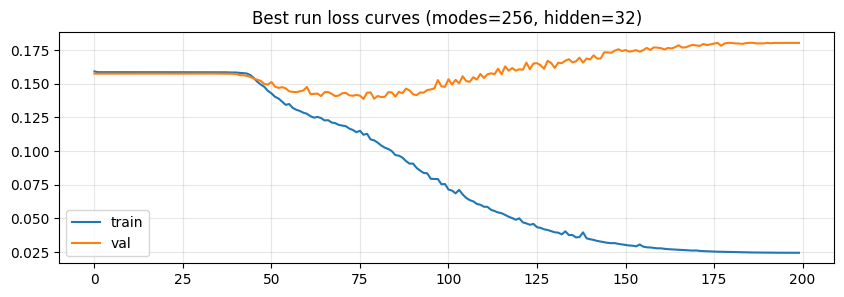

,n_modes,hidden,n_layers,best_epoch,val_mse_best,test_mse,val_corr,test_corr,val_rms_ratio,test_rms_ratio,val_alpha,test_alpha,time_sec
0,256,32,4,77,0.138790,0.135771,0.427511,0.402021,0.517320,0.483794,0.826427,0.830865,328.845308
1,192,32,4,117,0.139536,0.136599,0.577928,0.422909,0.477351,0.457742,1.210592,0.923751,329.901843
2,192,96,4,173,0.145394,0.142562,0.296640,0.205319,0.407369,0.305672,0.728127,0.671339,401.007718
3,256,96,4,166,0.147462,0.143031,0.172313,0.291389,0.332691,0.310885,0.517958,0.937308,423.854611
4,64,96,4,195,0.153754,0.155787,0.162334,-0.068674,0.095729,0.094347,1.695811,-0.727896,350.602434
5,64,32,4,162,0.154185,0.156730,0.116359,-0.050309,0.144291,0.163446,0.806419,-0.307782,236.725905
6,128,32,4,177,0.154746,0.157946,-0.040504,-0.099446,0.132045,0.108203,-0.306739,-0.919043,331.748621
7,192,64,4,197,0.156727,0.158022,-0.127518,0.019798,0.079102,0.078447,-1.612120,0.252372,335.736696
8,256,64,4,195,0.157124,0.158137,-0.322180,0.058459,0.047938,0.046894,-6.720884,1.246677,341.669509
9,64,64,4,12,0.157471,0.158261,0.081384,-0.108251,0.009807,0.009499,8.296721,-11.393545,313.368234


Saved: grid_search_results.csv


In [28]:
import pandas as pd

ranked = sorted(results, key=lambda d: d["val_mse_best"])
print("\nTop configs by val MSE:")
for r in ranked[:10]:
    print(f"modes={r['n_modes']:4d} hidden={r['hidden']:3d} "
          f"val={r['val_mse_best']:.6f} test={r['test_mse']:.6f} "
          f"test_corr={r['test_corr']:.3f} best_ep={r['best_epoch']} time={r['time_sec']:.1f}s")

best_run = ranked[0]
print("\nBEST RUN:", {k: best_run[k] for k in ["n_modes","hidden","n_layers","best_epoch","val_mse_best","test_mse","test_corr","test_rms_ratio","test_alpha"]})

# (선택) best loss curve plot
plt.figure(figsize=(10,3))
plt.plot(best_run["history"]["train"], label="train")
plt.plot(best_run["history"]["val"], label="val")
plt.legend(); plt.grid(True, alpha=0.3)
plt.title(f"Best run loss curves (modes={best_run['n_modes']}, hidden={best_run['hidden']})")
plt.show()

def results_to_df(results):
    rows = []
    for r in results:
        rows.append({
            "n_modes": r["n_modes"],
            "hidden": r["hidden"],
            "n_layers": r["n_layers"],
            "best_epoch": r["best_epoch"],
            "val_mse_best": r["val_mse_best"],
            "test_mse": r["test_mse"],
            "val_corr": r.get("val_corr", np.nan),
            "test_corr": r.get("test_corr", np.nan),
            "val_rms_ratio": r.get("val_rms_ratio", np.nan),
            "test_rms_ratio": r.get("test_rms_ratio", np.nan),
            "val_alpha": r.get("val_alpha", np.nan),
            "test_alpha": r.get("test_alpha", np.nan),
            "time_sec": r.get("time_sec", np.nan),
        })
    df = pd.DataFrame(rows)

    # 보기 좋게 정렬 (val 성능 우선)
    df = df.sort_values(["val_mse_best", "test_mse"], ascending=[True, True]).reset_index(drop=True)
    return df

df = results_to_df(results)

# 화면 출력(테이블)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
display(df)

# (선택) CSV로 저장
df.to_csv("grid_search_results.csv", index=False)
print("Saved: grid_search_results.csv")

## 10) Save model + configs + train-only norm stats

In [ ]:

OUT_DIR = Path("./outputs_fno1d")
OUT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = OUT_DIR / "fno1d_x_to_y.pt"
torch.save(model.state_dict(), ckpt_path)

cfg_path = OUT_DIR / "config.json"
bundle = {
    "split": asdict(cfg_split),
    "preproc": asdict(cfg_prep),
    "model": asdict(cfg_model),
    "train": asdict(cfg_train),
    "meta": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in meta.items()},
    "fs": fs,
    "seg_dur_sec": SEG_DUR_SEC,
}
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(bundle, f, indent=2, ensure_ascii=False)

stats_path = OUT_DIR / "norm_stats_train_only.npz"
if norm_stats is not None:
    np.savez(stats_path, **{k: v for k, v in norm_stats.items() if isinstance(v, np.ndarray)},
             mode=norm_stats.get("mode", "none"))
else:
    np.savez(stats_path, mode="none")

print("Saved:")
print(" -", ckpt_path)
print(" -", cfg_path)
print(" -", stats_path)
